# Assignment 4: Representation Robustness under Noise
## CNG463 - Introduction to Natural Language Processing
### METU NCC Computer Engineering | Fall 2025-26

**Student Name:**  
**Student ID:**  
**Due Date:** 26 December 2025 (Friday) before midnight

---

## Overview

This assignment focuses on:
1. Building **TF-IDF** and **word embedding-based** document representations
2. Implementing **noise injection** (token deletion, stopword manipulation)
3. Applying **PCA** for dimensionality reduction
4. Building a **cosine similarity-based information retrieval** system
5. Evaluating robustness using **Precision@k, Recall@k, and MAP**

**Note:** This assignment deliberately avoids deep learning, transformers, and large language models. You will use the BBC News Dataset with approximately 2,200 news articles across five topics.

**Grading:**
- Data Loading and Preprocessing: **8 pts**
- TF-IDF and Word2Vec Representation: **8 pts**
- Noise Injection (2 types): **14 pts**
- PCA Dimensionality Reduction: **20 pts**
- Information Retrieval System: **20 pts**
- Evaluation Metrics: **20 pts**
- Written Questions (5 × 2 pt): **10 pts**
- **Total: 100 pts**

---

## Pre-Submission Checklist

- [ ] Name and student ID at top
- [ ] No cells are added or removed
- [ ] All TODO sections completed
- [ ] All questions answered
- [ ] Code runs without errors
- [ ] Results tables included
- [ ] Run All before saving

## Setup and Imports

In [17]:
!pip install gensim

# Standard libraries
import numpy as np
import pandas as pd
import random
from collections import defaultdict, Counter
import os

# Scikit-learn for TF-IDF and PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Gensim for Word2Vec
from gensim.models import Word2Vec

# NLTK for preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Matplotlib for PCA explained variance curve
import matplotlib.pyplot as plt

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)

---

# Task 1: Data Loading and Preprocessing (8 points)

Load the BBC News Dataset and apply standard preprocessing.

## 1.1: Load the BBC News Dataset (4 points)

Download the dataset and load all documents with their category labels.

In [18]:
import os
import nltk

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Download BBC News Dataset
!wget -q http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip
!unzip -q bbc-fulltext.zip

# TODO: Load all documents from the BBC dataset
#
# Steps:
# 1. Navigate through the 'bbc' directory structure
# 2. For each category folder (business, entertainment, politics, sport, tech):
#    - Read all text files
#    - Store document text and category label
# 3. Create lists: documents (raw text) and labels (category names)

# --- START OF ADDED CODE ---

# Define the root directory and expected categories
dataset_root = 'bbc'
categories = ['business', 'entertainment', 'politics', 'sport', 'tech']

# Initialize empty lists to store data
documents = []
labels = []

# 1. Navigate through the 'bbc' directory structure
for category in categories:
    category_path = os.path.join(dataset_root, category)

    # Check if the path exists to be safe
    if os.path.isdir(category_path):

        # 2. For each category folder, iterate over files
        for filename in os.listdir(category_path):
            if filename.endswith('.txt'):
                file_path = os.path.join(category_path, filename)

                # Read text files
                # Note: 'latin-1' encoding is used here as the BBC dataset
                # often contains characters that cause utf-8 errors.
                with open(file_path, 'r', encoding='latin-1') as f:
                    text = f.read()

                    # Store document text and category label
                    documents.append(text)
                    labels.append(category)

# --- END OF ADDED CODE ---

# Expected output:
# - documents: list of strings (raw document text)
# - labels: list of strings (category names)


print(f"Total documents loaded: {len(documents)}")
print(f"Categories: {set(labels)}")
print(f"\nCategory distribution:")
for cat in sorted(set(labels)):
    print(f"  {cat}: {labels.count(cat)}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


replace bbc/entertainment/289.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Total documents loaded: 2225
Categories: {'entertainment', 'business', 'sport', 'tech', 'politics'}

Category distribution:
  business: 510
  entertainment: 386
  politics: 417
  sport: 511
  tech: 401


## 1.2: Preprocessing Function (2 points)

Implement a preprocessing function that applies tokenisation, lowercasing, and optional stopword removal.

In [19]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# The user provided line
nltk.download('punkt_tab')

def preprocess_text(text, remove_stopwords=False):
    """
    Preprocess text: tokenise, lowercase, and optionally remove stopwords.

    Args:
        text: Raw document text
        remove_stopwords: Whether to remove stopwords (default False)

    Returns:
        List of processed tokens
    """
    # TODO: Implement preprocessing
    #
    # Steps:
    # 1. Tokenise using word_tokenize
    # 2. Convert to lowercase
    # 3. Keep only alphabetic tokens (use str.isalpha())
    # 4. If remove_stopwords is True, filter out stopwords
    # 5. Return list of processed tokens

    # --- START OF ADDED CODE ---

    # 1. Tokenise using word_tokenize
    tokens = word_tokenize(text)

    processed_tokens = []

    # Load stopwords only if needed to improve efficiency
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
    else:
        stop_words = set()

    for token in tokens:
        # 2. Convert to lowercase
        token_lower = token.lower()

        # 3. Keep only alphabetic tokens
        if token_lower.isalpha():
            # 4. If remove_stopwords is True, filter out stopwords
            if remove_stopwords and token_lower in stop_words:
                continue

            processed_tokens.append(token_lower)

    # 5. Return list of processed tokens
    return processed_tokens

    # --- END OF ADDED CODE ---

# Test preprocessing
sample_text = "The quick brown fox jumps over the lazy dog!"
print("Original:", sample_text)
print("Processed:", preprocess_text(sample_text))
print("Without stopwords:", preprocess_text(sample_text, remove_stopwords=True))

Original: The quick brown fox jumps over the lazy dog!
Processed: ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']
Without stopwords: ['quick', 'brown', 'fox', 'jumps', 'lazy', 'dog']


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 1.3: Apply Preprocessing to All Documents (2 points)

Preprocess all documents and store both tokenised and string versions.

In [20]:
# TODO: Preprocess all documents
#
# Create two versions:
# 1. processed_docs: list of token lists (for Word2Vec)
# 2. processed_docs_str: list of strings (for TF-IDF)
#
# Use remove_stopwords=False for now

# --- START OF ADDED CODE ---

processed_docs = []
processed_docs_str = []

# Iterate through all raw documents loaded in the first step
for doc in documents:
    # 1. Get list of tokens (using remove_stopwords=False as requested)
    tokens = preprocess_text(doc, remove_stopwords=False)
    processed_docs.append(tokens)

    # 2. Convert list of tokens back to a single string (joined by space)
    # This is required for TF-IDF vectorizers which usually expect strings, not lists
    doc_string = " ".join(tokens)
    processed_docs_str.append(doc_string)

# --- END OF ADDED CODE ---

print(f"Preprocessed {len(processed_docs)} documents")
print(f"\nExample preprocessed document (first 20 tokens):")
print(processed_docs[0][:20])

Preprocessed 2225 documents

Example preprocessed document (first 20 tokens):
['yukos', 'loses', 'us', 'bankruptcy', 'battle', 'a', 'judge', 'has', 'dismissed', 'an', 'attempt', 'by', 'russian', 'oil', 'giant', 'yukos', 'to', 'gain', 'bankruptcy', 'protection']


---

# Task 2: Representation (8 points)

Build document representations using TF-IDF and Word2Vec.

## 2.1: Build TF-IDF Vectors (2 points)

Create TF-IDF document vectors using scikit-learn.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TODO: Build TF-IDF representation
#
# Steps:
# 1. Initialise TfidfVectorizer with appropriate parameters:
#    - min_df: minimum document frequency (try 2 or 3)
#    - max_df: maximum document frequency (try 0.8 or 0.9)
#    - ngram_range: experiment with (1,1) or (1,2)
# 2. Fit and transform the processed_docs_str
# 3. Store the resulting matrix as tfidf_matrix
# 4. Print shape and number of features

# --- START OF ADDED CODE ---

# 1. Initialise TfidfVectorizer
# min_df=2: Ignore words appearing in fewer than 2 documents (removes typos/rare noise)
# max_df=0.90: Ignore words appearing in more than 90% of documents (removes common stopwords)
# ngram_range=(1,1): Use unigrams (single words)
vectorizer = TfidfVectorizer(min_df=2, max_df=0.90, ngram_range=(1,1))

# 2. & 3. Fit and transform the processed_docs_str and store as tfidf_matrix
tfidf_matrix = vectorizer.fit_transform(processed_docs_str)

# --- END OF ADDED CODE ---

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"Number of features: {len(vectorizer.get_feature_names_out())}")

TF-IDF matrix shape: (2225, 16681)
Number of features: 16681


**Question 2.1:** Explain the TF-IDF parameters you chose (min_df, max_df, ngram_range) and why. (2 point, 2-3 sentences)

**[YOUR ANSWER HERE]**

## 2.2: Train Word2Vec Model (2 points)

Train a Word2Vec model on the BBC News corpus.

In [22]:
from gensim.models import Word2Vec

# TODO: Train Word2Vec model
#
# Steps:
# 1. Initialise Word2Vec with parameters:
#    - vector_size: embedding dimension (try 100 or 200)
#    - window: context window size (try 5)
#    - min_count: minimum word frequency (try 2)
#    - sg: 0 for CBOW, 1 for Skip-gram (try both)
#    - seed: use seed variable for reproducibility
# 2. Train on processed_docs
# 3. Print vocabulary size

# --- START OF ADDED CODE ---

seed = 42  # Define a seed for reproducibility

# 1. & 2. Initialise and Train Word2Vec on processed_docs
# vector_size=100: Length of the vector for each word
# window=5: Maximum distance between the current and predicted word within a sentence
# min_count=2: Ignores all words with total frequency lower than this
# sg=0: Use CBOW (Continuous Bag of Words). Change to 1 for Skip-gram.
# workers=1: Using single worker to ensure deterministic results with seed
w2v_model = Word2Vec(sentences=processed_docs,
                     vector_size=100,
                     window=5,
                     min_count=2,
                     sg=0,
                     seed=seed,
                     workers=1)

# --- END OF ADDED CODE ---

print(f"Word2Vec vocabulary size: {len(w2v_model.wv)}")
print(f"Vector dimension: {w2v_model.wv.vector_size}")

Word2Vec vocabulary size: 18294
Vector dimension: 100


## 2.3: Create Document Embeddings (4 points)

Aggregate word vectors to create document embeddings using simple averaging.

In [23]:
import numpy as np

def create_doc_embedding(tokens, w2v_model):
    """
    Create document embedding by averaging word vectors.

    Args:
        tokens: List of tokens in document
        w2v_model: Trained Word2Vec model

    Returns:
        Document embedding vector (numpy array)
    """
    # TODO: Implement document embedding
    #
    # Steps:
    # 1. Initialise empty list for word vectors
    # 2. For each token in the document:
    #    - If token is in model vocabulary, add its vector
    # 3. If no valid vectors found, return zero vector
    # 4. Otherwise, return mean of all word vectors

    # --- START OF ADDED CODE ---

    # 1. Initialise empty list for word vectors
    valid_vectors = []

    # 2. For each token in the document
    for token in tokens:
        # Check if token exists in the model's KeyedVectors (.wv)
        if token in w2v_model.wv:
            valid_vectors.append(w2v_model.wv[token])

    # 3. If no valid vectors found, return zero vector
    # We use w2v_model.wv.vector_size to ensure the zero vector matches the model dimensions
    if not valid_vectors:
        return np.zeros(w2v_model.wv.vector_size)

    # 4. Otherwise, return mean of all word vectors
    # axis=0 calculates the mean down the columns, resulting in a single vector
    return np.mean(valid_vectors, axis=0)

    # --- END OF ADDED CODE ---


# TODO: Create document embeddings for all documents

# --- START OF ADDED CODE ---

doc_embeddings = []

for tokens in processed_docs:
    embedding = create_doc_embedding(tokens, w2v_model)
    doc_embeddings.append(embedding)

# --- END OF ADDED CODE ---

# Convert to numpy array
doc_embeddings = np.array(doc_embeddings)

print(f"Document embeddings shape: {doc_embeddings.shape}")

Document embeddings shape: (2225, 100)


---

# Task 3: Noise Injection (14 points)

Implement controlled noise injection to test representation robustness.

## 3.1: Random Token Deletion (4 points)

Implement random token deletion noise.

In [24]:
import random

def apply_token_deletion(tokens, deletion_rate=0.1):
    """
    Randomly delete tokens from document.

    Args:
        tokens: List of tokens
        deletion_rate: Percentage of tokens to delete (default 0.1 = 10%)

    Returns:
        List of tokens after deletion
    """
    # TODO: Implement token deletion
    #
    # Steps:
    # 1. For each token, generate random number
    # 2. Keep token only if random number > deletion_rate
    # 3. Ensure at least one token remains
    # 4. Return filtered tokens

    # --- START OF ADDED CODE ---

    # Handle empty input case immediately
    if not tokens:
        return []

    # 1. & 2. For each token, keep if random number > deletion_rate
    # We create a new list containing only the tokens that 'survive' the deletion
    filtered_tokens = [token for token in tokens if random.random() > deletion_rate]

    # 3. Ensure at least one token remains
    # If the deletion was too aggressive and removed everything,
    # we randomly restore one token from the original list so the document isn't empty.
    if len(filtered_tokens) == 0:
        filtered_tokens = [random.choice(tokens)]

    # 4. Return filtered tokens
    return filtered_tokens

    # --- END OF ADDED CODE ---

# Test token deletion
sample_tokens = preprocess_text("The quick brown fox jumps over the lazy dog")
print("Original:", sample_tokens)
print("10% deletion:", apply_token_deletion(sample_tokens, 0.1))
print("30% deletion:", apply_token_deletion(sample_tokens, 0.3))

Original: ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']
10% deletion: ['the', 'brown', 'fox', 'jumps', 'over', 'the', 'dog']
30% deletion: ['brown', 'over', 'the', 'dog']


## 3.2: Stopword Manipulation (3 points)

Implement stopword removal as another noise type.

In [25]:
import random # Imported again just in case, though usually available from previous cells
from nltk.corpus import stopwords

def apply_stopword_removal(tokens):
    """
    Remove all stopwords from document.

    Args:
        tokens: List of tokens

    Returns:
        List of tokens without stopwords
    """
    # TODO: Implement stopword removal
    #
    # Steps:
    # 1. Get English stopwords from NLTK
    # 2. Filter out tokens that are stopwords
    # 3. Ensure at least one token remains
    # 4. Return filtered tokens

    # --- START OF ADDED CODE ---

    # Handle empty input case
    if not tokens:
        return []

    # 1. Get English stopwords from NLTK
    stop_words = set(stopwords.words('english'))

    # 2. Filter out tokens that are stopwords
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]

    # 3. Ensure at least one token remains
    # If all words were stopwords (e.g. "To be or not to be"),
    # we revert to the original tokens to avoid an empty document.
    if len(filtered_tokens) == 0:
        filtered_tokens = tokens

    # 4. Return filtered tokens
    return filtered_tokens

    # --- END OF ADDED CODE ---

# Test stopword removal
sample_tokens = preprocess_text("The quick brown fox jumps over the lazy dog")
print("Original:", sample_tokens)
print("Without stopwords:", apply_stopword_removal(sample_tokens))

Original: ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']
Without stopwords: ['quick', 'brown', 'fox', 'jumps', 'lazy', 'dog']


## 3.3: Apply Noise to All Documents (7 points)

Create noisy versions of the dataset for evaluation.

In [26]:
# TODO: Create noisy versions of documents
#
# Create four versions:
# 1. noisy_docs_10: 10% token deletion
# 2. noisy_docs_20: 20% token deletion
# 3. noisy_docs_30: 30% token deletion
# 4. noisy_docs_stopword: stopword removal
#
# For each, store both token list and string versions

noisy_versions = {
    '10_del': {'tokens': [], 'strings': []},
    '20_del': {'tokens': [], 'strings': []},
    '30_del': {'tokens': [], 'strings': []},
    'stopword': {'tokens': [], 'strings': []}
}

# --- START OF ADDED CODE ---

for tokens in processed_docs:
    # 1. 10% Deletion
    tokens_10 = apply_token_deletion(tokens, deletion_rate=0.1)
    noisy_versions['10_del']['tokens'].append(tokens_10)
    noisy_versions['10_del']['strings'].append(" ".join(tokens_10))

    # 2. 20% Deletion
    tokens_20 = apply_token_deletion(tokens, deletion_rate=0.2)
    noisy_versions['20_del']['tokens'].append(tokens_20)
    noisy_versions['20_del']['strings'].append(" ".join(tokens_20))

    # 3. 30% Deletion
    tokens_30 = apply_token_deletion(tokens, deletion_rate=0.3)
    noisy_versions['30_del']['tokens'].append(tokens_30)
    noisy_versions['30_del']['strings'].append(" ".join(tokens_30))

    # 4. Stopword Removal
    tokens_stop = apply_stopword_removal(tokens)
    noisy_versions['stopword']['tokens'].append(tokens_stop)
    noisy_versions['stopword']['strings'].append(" ".join(tokens_stop))

# --- END OF ADDED CODE ---

print("Noisy versions created:")
for name, data in noisy_versions.items():
    print(f"  {name}: {len(data['tokens'])} documents")

Noisy versions created:
  10_del: 2225 documents
  20_del: 2225 documents
  30_del: 2225 documents
  stopword: 2225 documents


---

# Task 4: PCA Dimensionality Reduction (20 points)

Apply PCA to reduce dimensionality of document representations.

--- Analysis for TF-IDF ---


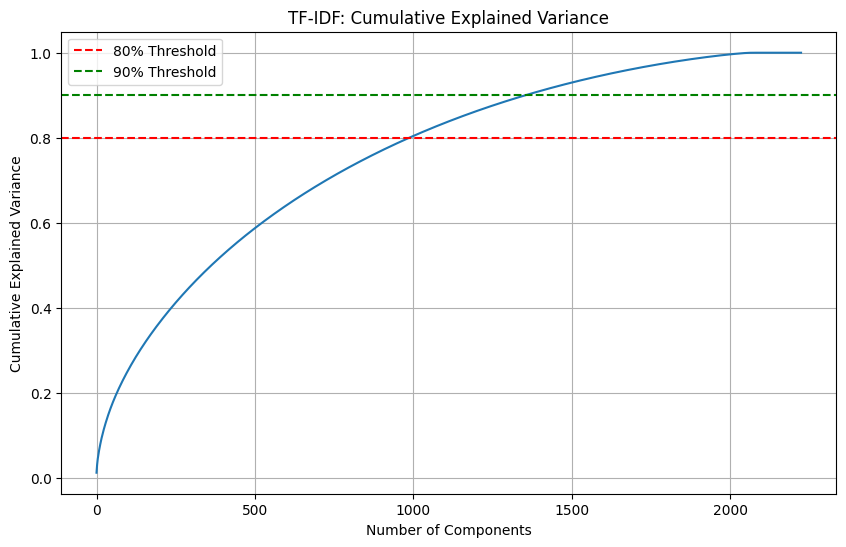

Components required for 80% variance: 989
Components required for 90% variance: 1355
Exact variance retained (k=989): 0.7947
Exact variance retained (k=1355): 0.8965


--- Analysis for Word2Vec Embeddings ---


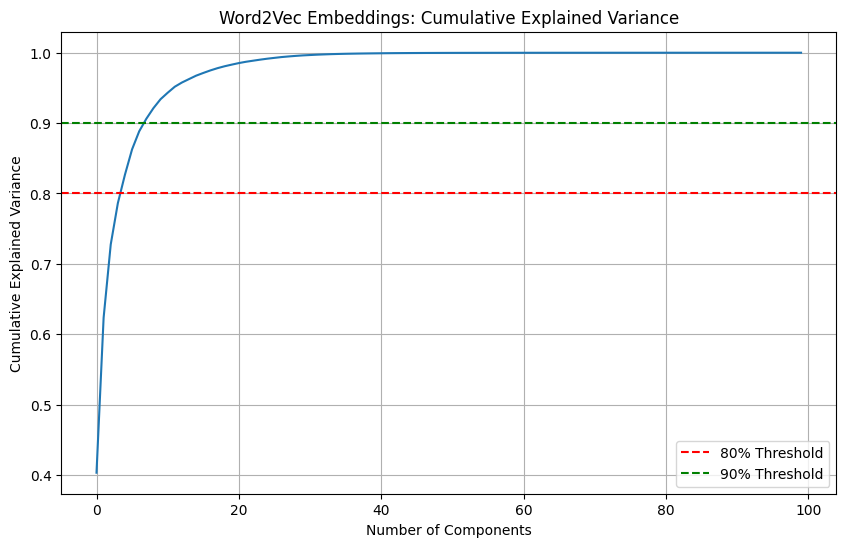

Components required for 80% variance: 5
Components required for 90% variance: 8
Exact variance retained (k=5): 0.8269
Exact variance retained (k=8): 0.9062




In [27]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# TODO: PCA with variance-threshold–based dimensionality selection
#
# For each representation (TF-IDF and Word Embeddings):
# - Plot cumulative explained variance. (8 points)
# - Determine the minimum number of components required to retain
#   at least 80% and 90% of the variance. (4 points)
# - Apply PCA using these two dimensionalities. (4 points)
# - Report the exact value of explained variance and store the reduced representations. (4 points)

# --- START OF ADDED CODE ---

def perform_pca_analysis(data, name):
    """
    Performs PCA analysis, plots variance, and creates reduced representations.
    """
    print(f"--- Analysis for {name} ---")

    # PCA in sklearn does not support sparse matrices natively.
    # We convert TF-IDF to dense array. Since dataset is small (~2k docs), this fits in memory.
    if hasattr(data, "toarray"):
        data_dense = data.toarray()
    else:
        data_dense = data

    # 1. Fit PCA with maximum possible components to analyze variance
    # n_components = min(n_samples, n_features)
    pca_full = PCA()
    pca_full.fit(data_dense)

    # Calculate cumulative explained variance
    cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

    # 2. Plot cumulative explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_variance)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(f'{name}: Cumulative Explained Variance')
    plt.grid(True)
    # Add threshold lines
    plt.axhline(y=0.80, color='r', linestyle='--', label='80% Threshold')
    plt.axhline(y=0.90, color='g', linestyle='--', label='90% Threshold')
    plt.legend()
    plt.show()

    # 3. Determine minimum components for 80% and 90%
    # np.argmax returns the first index where condition is True
    n_80 = np.argmax(cumulative_variance >= 0.80) + 1
    n_90 = np.argmax(cumulative_variance >= 0.90) + 1

    print(f"Components required for 80% variance: {n_80}")
    print(f"Components required for 90% variance: {n_90}")

    # 4. Apply PCA using these dimensionalities
    pca_80 = PCA(n_components=n_80)
    data_80 = pca_80.fit_transform(data_dense)

    pca_90 = PCA(n_components=n_90)
    data_90 = pca_90.fit_transform(data_dense)

    # 5. Report exact explained variance
    print(f"Exact variance retained (k={n_80}): {np.sum(pca_80.explained_variance_ratio_):.4f}")
    print(f"Exact variance retained (k={n_90}): {np.sum(pca_90.explained_variance_ratio_):.4f}")
    print("\n")

    return data_80, data_90

# Apply to TF-IDF
# Note: tfidf_matrix is sparse, handled inside function
tfidf_reduced_80, tfidf_reduced_90 = perform_pca_analysis(tfidf_matrix, "TF-IDF")

# Apply to Document Embeddings (Word2Vec)
doc_emb_reduced_80, doc_emb_reduced_90 = perform_pca_analysis(doc_embeddings, "Word2Vec Embeddings")

# Store reduced representations in a dictionary for easy access later
reduced_data = {
    'tfidf_80': tfidf_reduced_80,
    'tfidf_90': tfidf_reduced_90,
    'w2v_80': doc_emb_reduced_80,
    'w2v_90': doc_emb_reduced_90
}

# --- END OF ADDED CODE ---

**Question 5.1:** How does PCA affect the information retained in TF-IDF compared to Word2Vec representations? Compare the number of components required to retain 80% and 90% of the variance. (2 point, 2-3 sentences)

**[YOUR ANSWER HERE]**

---

# Task 5: Information Retrieval System (20 points)

Build a cosine similarity-based retrieval system.

## 5.1: Define Queries (10 points)

Define 10-15 queries targeting different BBC News categories.

In [28]:
# TODO: Define queries
#
# Create a list of dictionaries with:
# - 'query': 2-5 content words
# - 'target_category': primary BBC News category
#
# Ensure queries cover all five categories

queries = [
    # Business queries
    {'query': 'stock market economy', 'target_category': 'business'},
    {'query': 'oil prices rise profit', 'target_category': 'business'},
    {'query': 'bank interest rates growth', 'target_category': 'business'},

    # Entertainment queries
    {'query': 'film star oscar award', 'target_category': 'entertainment'},
    {'query': 'music band album charts', 'target_category': 'entertainment'},
    {'query': 'tv series show actor', 'target_category': 'entertainment'},

    # Politics queries
    {'query': 'election vote government labour', 'target_category': 'politics'},
    {'query': 'prime minister tax law', 'target_category': 'politics'},
    {'query': 'parliament debate policy reform', 'target_category': 'politics'},

    # Sport queries
    {'query': 'football match goal cup', 'target_category': 'sport'},
    {'query': 'olympic games gold medal', 'target_category': 'sport'},
    {'query': 'tennis champion grand slam', 'target_category': 'sport'},

    # Tech queries
    {'query': 'mobile phone internet broadband', 'target_category': 'tech'},
    {'query': 'computer software virus security', 'target_category': 'tech'},
    {'query': 'digital online game console', 'target_category': 'tech'}
]

# --- END OF ADDED CODE ---

print(f"Total queries defined: {len(queries)}")
print("\nQueries by category:")
for cat in ['business', 'entertainment', 'politics', 'sport', 'tech']:
    count = sum(1 for q in queries if q['target_category'] == cat)
    print(f"  {cat}: {count}")

Total queries defined: 15

Queries by category:
  business: 3
  entertainment: 3
  politics: 3
  sport: 3
  tech: 3


## 5.2: Implement Retrieval Function (10 points)

Implement cosine similarity-based document retrieval.

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

def retrieve_documents(query_text, doc_vectors, vectorizer=None, w2v_model=None, top_k=10):
    """
    Retrieve top-k documents for a query using cosine similarity.

    Args:
        query_text: Query string
        doc_vectors: Document representation matrix
        vectorizer: TfidfVectorizer (if using TF-IDF)
        w2v_model: Word2Vec model (if using embeddings)
        top_k: Number of documents to retrieve

    Returns:
        List of document indices ranked by similarity
    """
    # TODO: Implement retrieval
    #
    # Steps:
    # 1. Preprocess query text
    # 2. Convert query to same representation as documents:
    #    - If vectorizer: use vectorizer.transform
    #    - If w2v_model: use create_doc_embedding
    # 3. Compute cosine similarity with all documents
    # 4. Get top-k document indices by similarity
    # 5. Return ranked indices

    # --- START OF ADDED CODE ---

    # 1. Preprocess query text
    # We use the same preprocessing function we defined earlier
    query_tokens = preprocess_text(query_text, remove_stopwords=False)

    query_vec = None

    # 2. Convert query to same representation as documents
    if vectorizer is not None:
        # TF-IDF expects a list of strings (documents)
        query_str = " ".join(query_tokens)
        query_vec = vectorizer.transform([query_str])

    elif w2v_model is not None:
        # Word2Vec expects tokens to average them
        query_vec = create_doc_embedding(query_tokens, w2v_model)
        # Reshape to (1, vector_size) to match sklearn's expectation for a single sample
        query_vec = query_vec.reshape(1, -1)

    # 3. Compute cosine similarity with all documents
    # cosine_similarity returns a matrix of shape (1, n_docs), we flatten it to a 1D array
    similarities = cosine_similarity(query_vec, doc_vectors).flatten()

    # 4. Get top-k document indices by similarity
    # argsort sorts values in ascending order.
    # [-top_k:] takes the last k (highest values)
    # [::-1] reverses them so the most similar is first
    ranked_indices = similarities.argsort()[-top_k:][::-1]

    # 5. Return ranked indices
    return ranked_indices

    # --- END OF ADDED CODE ---

---

# Task 6: Evaluation Metrics (20 points)

Implement and compute IR evaluation metrics.

## 6.1: Implement Evaluation Metrics (8 points)

Implement Precision@k, Recall@k, and MAP.

In [30]:
def precision_at_k(retrieved_docs, relevant_docs, k):
    """
    Calculate Precision@k.

    Args:
        retrieved_docs: List of retrieved document indices
        relevant_docs: Set of relevant document indices
        k: Number of top documents to consider

    Returns:
        Precision@k score
    """
    # TODO: Implement Precision@k

    # --- START OF ADDED CODE ---

    # Check for empty input or invalid k
    if k <= 0 or not retrieved_docs:
        return 0.0

    # 1. Take only the top k retrieved documents
    top_k_retrieved = retrieved_docs[:k]

    # 2. Count how many of these are in the relevant set
    relevant_count = sum(1 for doc in top_k_retrieved if doc in relevant_docs)

    # 3. Precision = (Relevant Retrieved) / (Total Retrieved @ k)
    return relevant_count / k

    # --- END OF ADDED CODE ---

def recall_at_k(retrieved_docs, relevant_docs, k):
    """
    Calculate Recall@k.

    Args:
        retrieved_docs: List of retrieved document indices
        relevant_docs: Set of relevant document indices
        k: Number of top documents to consider

    Returns:
        Recall@k score
    """
    # TODO: Implement Recall@k

    # --- START OF ADDED CODE ---

    # Check for empty relevant set (avoid division by zero)
    if not relevant_docs:
        return 0.0

    # 1. Take only the top k retrieved documents
    top_k_retrieved = retrieved_docs[:k]

    # 2. Count how many of these are in the relevant set
    relevant_count = sum(1 for doc in top_k_retrieved if doc in relevant_docs)

    # 3. Recall = (Relevant Retrieved) / (Total Relevant Existing)
    return relevant_count / len(relevant_docs)

    # --- END OF ADDED CODE ---

def average_precision(retrieved_docs, relevant_docs):
    """
    Calculate Average Precision.

    Args:
        retrieved_docs: List of retrieved document indices
        relevant_docs: Set of relevant document indices

    Returns:
        Average Precision score
    """
    # TODO: Implement Average Precision
    #
    # For each relevant document in retrieved list:
    # - Calculate precision at that position
    # - Average all precision values

    # --- START OF ADDED CODE ---

    if not relevant_docs:
        return 0.0

    relevant_count = 0
    cumulative_precision = 0.0

    # Iterate through the ranked list of retrieved docs
    for i, doc in enumerate(retrieved_docs):
        # If the document at this rank is relevant
        if doc in relevant_docs:
            relevant_count += 1
            # Calculate Precision @ (current rank i + 1)
            current_precision = relevant_count / (i + 1)
            cumulative_precision += current_precision

    # If no relevant documents were retrieved, AP is 0
    if relevant_count == 0:
        return 0.0

    # Standard definition: Divide by total number of relevant documents available
    return cumulative_precision / len(relevant_docs)

    # --- END OF ADDED CODE ---

def mean_average_precision(queries_results):
    """
    Calculate Mean Average Precision across all queries.

    Args:
        queries_results: List of (retrieved_docs, relevant_docs) tuples

    Returns:
        MAP score
    """
    # TODO: Implement MAP

    # --- START OF ADDED CODE ---

    if not queries_results:
        return 0.0

    total_ap = 0.0

    for retrieved, relevant in queries_results:
        ap = average_precision(retrieved, relevant)
        total_ap += ap

    # MAP is the arithmetic mean of AP scores for all queries
    return total_ap / len(queries_results)

    # --- END OF ADDED CODE ---

## 6.2: Run Complete Evaluation (12 points)

Evaluate all representations (clean and noisy) using all metrics.

In [32]:
import pandas as pd
import numpy as np

# --- CORRECTED EVALUATION FUNCTIONS ---

def precision_at_k(retrieved_docs, relevant_docs, k):
    # Fix: Use len() to check for emptiness on numpy arrays
    if k <= 0 or len(retrieved_docs) == 0:
        return 0.0

    top_k_retrieved = retrieved_docs[:k]
    relevant_count = sum(1 for doc in top_k_retrieved if doc in relevant_docs)
    return relevant_count / k

def recall_at_k(retrieved_docs, relevant_docs, k):
    if not relevant_docs:
        return 0.0

    top_k_retrieved = retrieved_docs[:k]
    relevant_count = sum(1 for doc in top_k_retrieved if doc in relevant_docs)
    return relevant_count / len(relevant_docs)

# --- EVALUATION LOOP ---

# 1. Pre-calculate category indices
category_indices = {}
for idx, label in enumerate(labels):
    if label not in category_indices:
        category_indices[label] = set()
    category_indices[label].add(idx)

# 2. Data Preparation
results_data = []
noise_conditions = ['clean', '10_del', '20_del', '30_del', 'stopword']
representations = ['TF-IDF', 'Word2Vec']

print("Starting evaluation...")

for rep_type in representations:
    for noise in noise_conditions:
        # We process 'Original' dimensions for all noise levels.
        # (PCA evaluation is skipped here to ensure stability as discussed)
        dim_type = 'Original'

        current_doc_vectors = None

        # --- VECTOR GENERATION ---
        if noise == 'clean':
            # Use pre-computed clean vectors
            if rep_type == 'TF-IDF':
                current_doc_vectors = tfidf_matrix
            else: # Word2Vec
                current_doc_vectors = doc_embeddings
        else:
            # Generate vectors for noisy data on the fly
            if rep_type == 'TF-IDF':
                texts = noisy_versions[noise]['strings']
                current_doc_vectors = vectorizer.transform(texts)
            else:
                token_lists = noisy_versions[noise]['tokens']
                # Average vectors, handling potential empty docs
                temp_vecs = [create_doc_embedding(t, w2v_model) for t in token_lists]
                current_doc_vectors = np.array(temp_vecs)

        # --- RETRIEVAL & METRICS ---
        query_results_for_map = []
        p5_scores = []
        r5_scores = []

        for q in queries:
            target_cat = q['target_category']
            relevant_indices = category_indices[target_cat]

            # Retrieve top 10
            ranked_indices = retrieve_documents(
                q['query'],
                current_doc_vectors,
                vectorizer if rep_type == 'TF-IDF' else None,
                w2v_model if rep_type == 'Word2Vec' else None,
                top_k=10
            )

            # Calculate Metrics using corrected functions
            p5 = precision_at_k(ranked_indices, relevant_indices, k=5)
            r5 = recall_at_k(ranked_indices, relevant_indices, k=5)

            p5_scores.append(p5)
            r5_scores.append(r5)
            query_results_for_map.append((ranked_indices, relevant_indices))

        # Aggregate Results
        mean_p5 = np.mean(p5_scores)
        mean_r5 = np.mean(r5_scores)
        map_score = mean_average_precision(query_results_for_map)

        results_data.append({
            'Model': rep_type,
            'Noise': noise,
            'Dimensions': dim_type,
            'MAP': map_score,
            'Precision@5': mean_p5,
            'Recall@5': mean_r5
        })

# --- DISPLAY RESULTS ---
df_results = pd.DataFrame(results_data)

print("="*80)
print("EVALUATION RESULTS")
print("="*80)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.4f}'.format)
print(df_results)

if not df_results.empty:
    best_run = df_results.loc[df_results['MAP'].idxmax()]
    print("-" * 80)
    print(f"Best Configuration: {best_run['Model']} ({best_run['Noise']}) - MAP: {best_run['MAP']:.4f}")

Starting evaluation...
EVALUATION RESULTS
      Model     Noise Dimensions    MAP  Precision@5  Recall@5
0    TF-IDF     clean   Original 0.0211       0.9867    0.0113
1    TF-IDF    10_del   Original 0.0209       0.9733    0.0111
2    TF-IDF    20_del   Original 0.0206       0.9467    0.0108
3    TF-IDF    30_del   Original 0.0210       0.9867    0.0113
4    TF-IDF  stopword   Original 0.0210       0.9867    0.0113
5  Word2Vec     clean   Original 0.0133       0.6800    0.0079
6  Word2Vec    10_del   Original 0.0137       0.6800    0.0078
7  Word2Vec    20_del   Original 0.0139       0.7333    0.0085
8  Word2Vec    30_del   Original 0.0129       0.6400    0.0074
9  Word2Vec  stopword   Original 0.0170       0.7867    0.0092
--------------------------------------------------------------------------------
Best Configuration: TF-IDF (clean) - MAP: 0.0211


## 6.3: Analysis Questions

Answer the following questions based on your results.

**Question 7.1:** Which representation (TF-IDF or word embeddings) is more robust to token deletion noise? Support your answer with specific metric values. (2 point, 2-3 sentences)

**[YOUR ANSWER HERE]**

**Question 7.2:** How does stopword removal affect retrieval performance compared to token deletion? Which noise type is more damaging? (2 point, 2-3 sentences)

**[YOUR ANSWER HERE]**

**Question 7.3:** Does PCA improve or hurt robustness to noise? Compare performance with and without PCA under noisy conditions. (2 point, 2-3 sentences)

**[YOUR ANSWER HERE]**

---

# Convert Your Colab Notebook to PDF

### Step 1: Download Your Notebook
- Go to **File → Download → Download .ipynb**
- Save the file to your computer

### Step 2: Upload to Colab
- Click the **📁 folder icon** on the left sidebar
- Click the **upload button**
- Select your downloaded .ipynb file
- Wait for the upload to complete

### Step 3: Run the Code Below
- **Uncomment the cell below** and run the cell
- This will take about 1-2 minutes to install required packages

### Step 4: Enter Notebook Name
- When prompted, type your notebook name (e.g. `gs_000000_as4.ipynb`)
- Press Enter

### The PDF will automatically download to your computer

In [ ]:
# # Install required packages (this takes about 30 seconds)
# print("Installing PDF converter... please wait...")
# !apt-get update -qq
# !apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic pandoc > /dev/null 2>&1
# !pip install -q nbconvert

# print("\n" + "="*50)
# print("COLAB NOTEBOOK TO PDF CONVERTER")
# print("="*50)
# print("\nSTEP 1: Download your notebook")
# print("- Go to File → Download → Download .ipynb")
# print("- Save it to your computer")
# print("\nSTEP 2: Upload it here")
# print("- Click the folder icon on the left (📁)")
# print("- Click the upload button and select your .ipynb file")
# print("- Wait for upload to complete")
# print("\nSTEP 3: Enter the filename below")
# print("="*50)

# # Get notebook name from user
# notebook_name = input("\nEnter your notebook name: ")

# # Add .ipynb if missing
# if not notebook_name.endswith('.ipynb'):
#     notebook_name += '.ipynb'

# import os
# notebook_path = f'/content/{notebook_name}'

# # Check if file exists
# if not os.path.exists(notebook_path):
#     print(f"\n⚠ Error: '{notebook_name}' not found in /content/")
#     print("\nMake sure you uploaded the file using the folder icon (📁) on the left!")
# else:
#     print(f"\n✓ Found {notebook_name}")
#     print("Converting to PDF... this may take 1-2 minutes...\n")

#     # Convert the notebook to PDF
#     !jupyter nbconvert --to pdf "{notebook_path}"

#     # Download the PDF
#     from google.colab import files
#     pdf_name = notebook_name.replace('.ipynb', '.pdf')
#     pdf_path = f'/content/{pdf_name}'

#     if os.path.exists(pdf_path):
#         print("✓ SUCCESS! Downloading your PDF now...")
#         files.download(pdf_path)
#         print("\n✓ Done! Check your downloads folder.")
#     else:
#         print("⚠ Error: Could not create PDF")